In [2]:
# Exploring the covariance in segregating sites
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

import sys
sys.path.append('../../src/')
from plot_utils import *

from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress
from geopy.distance import geodesic

%load_ext autoreload
%autoreload 2

In [3]:
# NOTE : this should be from the plot utils 
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker


f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)

import os
main_figdir = '../../plots/hap_copying/jump_rate_chrXdata/'
supp_figdir = '../../plots/supp_figs/hap_copying/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

%matplotlib inline

## Obtaining Raw Statistics from a 1KG Panel

In [4]:
total_raw_stats_df = pd.read_csv('../../results/hap_copying/chrX_male_analysis/mle_est_real_1kg/chrX_filt.total.ls_stats.merged.csv')
total_raw_stats_df.head()

,indivID,Country,Location,Lat,Long,AvgDate_calBP,Sex,Cov_Autosomes,Data_Type,Publication,...,panelID,scale_marginal,se_marginal,se_scale_marginal_fd,scale_jt,se_scale_jt,eps_jt,se_eps_jt,nsnps,nref_haps
0,I1137_all_published,Vietnam,Man Bac,20.13333333,105.9833333,3764,M,0.136147,1240K,LipsonScience2018,...,ceu,1375.245806,47.237993,46.318122,1268.975116,1.015457,0.081034,0.003233,1403,49
1,I1137_all_published,Vietnam,Man Bac,20.13333333,105.9833333,3764,M,0.136147,1240K,LipsonScience2018,...,eur,974.143408,15.615194,15.821732,672.650947,6.342667,0.057088,0.001266,1603,240
2,I1137_all_published,Vietnam,Man Bac,20.13333333,105.9833333,3764,M,0.136147,1240K,LipsonScience2018,...,fullkg,188.762619,1.026639,1.017737,188.739182,1.000000,0.013873,0.000048,2223,1233
3,I4451_all,Vanuatu,"Efate, Mele-Taplins",-17.689401,168.289509,2260,M,1.549016,1240K,LipsonCurrentBiology2018,...,ceu,1120.447467,10.797309,10.845776,923.859818,5.585431,0.035393,0.000388,11503,49
4,I4451_all,Vanuatu,"Efate, Mele-Taplins",-17.689401,168.289509,2260,M,1.549016,1240K,LipsonCurrentBiology2018,...,eur,796.898418,3.807525,3.770875,672.993531,28.331141,0.024265,0.000355,13150,240


In [5]:
# Do a little filtering on the number of snps per kb

snps_kb_threshold = 1
nsnps = 10000
# options for panel: (ceu|eur|fullkg)
panel = 'ceu'

# Make sure the individuals "PASS" according to the Reich-Lab assessment
pass_indices = np.array(['PASS' in total_raw_stats_df['Assessment'].values[i] for i in range(total_raw_stats_df.shape[0])])
pass_indivs_raw = total_raw_stats_df.iloc[np.where(pass_indices)[0]]
pass_indivs_filt_nsnps = pass_indivs_raw[(pass_indivs_raw['nsnps'] >= nsnps)]
pass_indivs = pass_indivs_filt_nsnps[pass_indivs_filt_nsnps.panelID == panel]

# NOTE: should have a way to filter duplicate samples (and only take the higher coverage sample ... )
pass_indivs.head()

,indivID,Country,Location,Lat,Long,AvgDate_calBP,Sex,Cov_Autosomes,Data_Type,Publication,...,panelID,scale_marginal,se_marginal,se_scale_marginal_fd,scale_jt,se_scale_jt,eps_jt,se_eps_jt,nsnps,nref_haps
3,I4451_all,Vanuatu,"Efate, Mele-Taplins",-17.689401,168.289509,2260,M,1.549016,1240K,LipsonCurrentBiology2018,...,ceu,1120.447467,10.797309,10.845776,923.859818,5.585431,0.035393,0.000388,11503,49
30,I4246_published,Spain,"Madrid, San Fernando de Henares, Camino de las...",40.439722,-3.506389,4202,M,1.128632,1240K,OlaldeScience2019,...,ceu,998.512576,11.041003,11.069112,923.720218,1.989108,0.029713,0.000536,10105,49
36,I7207,Czech Republic,Radovesice,50.410265,14.074597,4400,M,1.863154,1240K,NarasimhanPattersonScience2019,...,ceu,463.535410,4.519468,4.528419,489.364987,2.825274,0.010500,0.000271,12268,49
39,I7208,Czech Republic,Radovesice,50.410265,14.074597,4330,M,1.962270,1240K,NarasimhanPattersonScience2019,...,ceu,391.006126,4.059121,4.000698,356.284490,5.673304,0.011690,0.000093,12899,49
42,I7209,Czech Republic,Radovesice,50.410265,14.074597,4283,M,4.120915,1240K,NarasimhanPattersonScience2019,...,ceu,447.624959,4.488343,4.479032,356.401449,13.896382,0.013745,0.000089,14691,49


3.631243607246377 3.7286224029465065 2.7779605 690


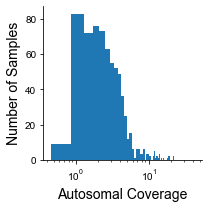

In [6]:
cov_auto = pass_indivs['Cov_Autosomes']
print(np.nanmean(cov_auto), np.nanstd(cov_auto), np.median(cov_auto), cov_auto.size)
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.hist(cov_auto, bins=100);
debox(ax);
ax.set_xscale('log')
ax.set_xlabel(r'Autosomal Coverage', fontsize=14);
ax.set_ylabel(r'Number of Samples', fontsize=14);

In [7]:
mean_age = pass_indivs.groupby('Country').mean()['AvgDate_calBP']
std_age = pass_indivs.groupby('Country').std()['AvgDate_calBP']
min_age = pass_indivs.groupby('Country')['AvgDate_calBP'].min()
max_age = pass_indivs.groupby('Country')['AvgDate_calBP'].max()

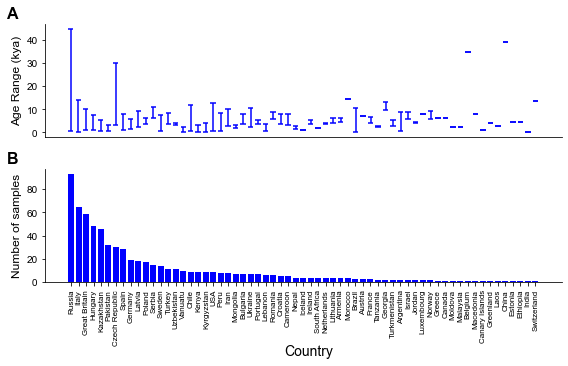

In [8]:
countries, cnts = np.unique(pass_indivs.Country, return_counts=True)
# Return countries in reverse chronological order 
countries_srt = countries[np.argsort(cnts)[::-1]]
cnts_srt = np.sort(cnts)[::-1]

# Make a plot of this information
fig, ax = plt.subplots(2,1,figsize=(8,5))
ax[1].bar(countries_srt, cnts_srt, color='blue')

for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(8);
    
delta=0.35
i = 0
for c in countries_srt:
    cur_min_age = min_age[c]
    cur_max_age = max_age[c]
    ax[0].plot([i,i], [min_age[c]/1e3, max_age[c]/1e3], color='blue', solid_capstyle='butt')
    ax[0].plot([i-delta,i+delta], [min_age[c]/1e3, min_age[c]/1e3], color='blue', solid_capstyle='butt')
    ax[0].plot([i-delta,i+delta], [max_age[c]/1e3, max_age[c]/1e3], color='blue', solid_capstyle='butt')
    i += 1
ax[0].set_xticks([])
ax[0].set_ylabel(r'Age Range (kya)', fontsize=12)
ax[1].set_ylabel(r'Number of samples', fontsize=12)

fig.text(0.5, 0.00, 'Country', fontsize=14)
debox(ax[1]); debox(ax[0]);

for i, label in enumerate(('A', 'B')):
    ax[i].text(-0.05, 1.15, label, fontsize=16, 
               fontweight='bold', va='top', ha='right', transform=ax[i].transAxes);

plt.tight_layout()
plt.savefig(supp_figdir + 'panel_%s_thresh_%d_countries_vs_age.pdf' % (panel, nsnps), bbox_inches='tight', dpi=300)

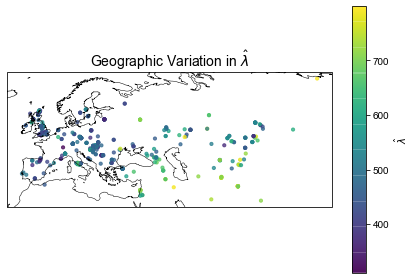

In [9]:
global_lats = pass_indivs.Lat
global_longs = pass_indivs.Long
global_lambda = pass_indivs.scale_marginal
global_lambda_se = pass_indivs.se_scale_marginal_fd
global_age = pass_indivs.AvgDate_calBP

# Some filters here with the distance here  
idx = (global_lats != '..') & (global_longs != '..') & (global_lambda < 8e2)

ax = plt.axes(projection=ccrs.Robinson())
# ax.set_global()
ax.coastlines(lw=0.5)
im = ax.scatter(global_longs[idx].values.astype(float), 
           global_lats[idx].values.astype(float), 
           c=global_lambda[idx].values.astype(float),
           transform=ccrs.PlateCarree(), s=10, alpha=0.75)

ax.set_title(r'Geographic Variation in $\hat{\lambda}$', fontsize=14)
plt.colorbar(im, label=r'$\hat{\lambda}$')
# plt.show()
# plt.savefig(supp_figdir + 'eurasia_panel_%s_global_lambda_%d.pdf' % (test_panel, snps_kb_threshold), bbox_inches='tight', dpi=300)

In [10]:
# Calculate Distance from central europe (ideally add as another annotation)
test_longs = global_longs[idx].values.astype(float)
test_lats = global_lats[idx].values.astype(float)
test_lambda = global_lambda[idx].values.astype(float)
test_lambda_se = global_lambda_se[idx].values.astype(float)
test_ages = global_age[idx].values.astype(float)

assert(test_longs.size == test_lats.size)
assert(test_longs.size == test_lambda.size)

ceu_coords = (48., 6.)
geo_dist_ceu = np.zeros(test_longs.size)
for i in tqdm(range(test_longs.size)):
    geo_dist_ceu[i] = geodesic(ceu_coords, (test_lats[i], test_longs[i])).kilometers
    
# Putting in the distances from CEU coordinates here ... 
dist = np.zeros(pass_indivs.shape[0])
dist[idx] = geo_dist_ceu
pass_indivs['CEU_dist'] = dist

100%|██████████| 495/495 [00:00<00:00, 2527.91it/s]
/Users/Biddanda/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/Biddanda/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
No handles with labels found to put in legend.


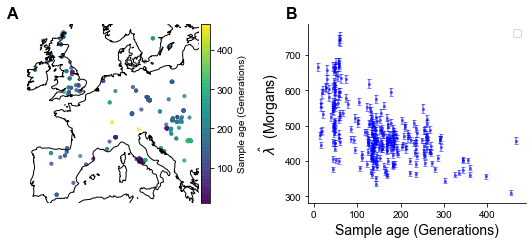

In [11]:
#Do the slight filtering here ... 
km_thresh = 1500
gen_time = 30.
test_df = pass_indivs[(pass_indivs.CEU_dist != 0) & (pass_indivs.CEU_dist <= km_thresh) & (pass_indivs.AvgDate_calBP <= 1.5e4)]
test_df = test_df.astype({'Lat': 'float64', 'Long': 'float64', 'AvgDate_calBP': 'float64', 'Cov_Autosomes': 'float64'})
test_df['AvgDateGenerations'] = test_df.AvgDate_calBP.values / gen_time 

fig = plt.figure(figsize=(7.5,3.5))
gs = fig.add_gridspec(1, 6)


# age_gen = test_df.AvgDateGenerations.values.astype(float)
age_gen = test_df.AvgDateGenerations.values.astype(float)

ax1 = fig.add_subplot(gs[:, :3], projection=ccrs.PlateCarree())
ax1.coastlines(resolution='auto', color='k')
im = ax1.scatter(test_df.Long.values.astype(float), 
           test_df.Lat.values.astype(float),
           transform=ccrs.PlateCarree(), c=age_gen, s=10, alpha=0.75)

fig.colorbar(im, ax=ax1, orientation='vertical', pad=0.01, fraction=0.2, label=r'Sample age (Generations)')

ax1.set_aspect('auto')
ax1.outline_patch.set_visible(False)
debox(ax1);

# NOTE : try to accomplish this with a LO

# Linear Model to check for effect of age 
# NOTE : this accounts for lat/long and their interaction term)
# y, X = dmatrices('mle_lambda_jt ~ AvgDateGenerations + Lat + Long + Lat:Long', 
#                  data=test_df,
#                  return_type='dataframe')

# res = sm.OLS(y,X).fit()
# intercept = res.params['Intercept']
# beta_age = res.params['AvgDateGenerations']
# p_value = res.pvalues['AvgDateGenerations']

marginal_lambda = test_df.scale_marginal.values
marginal_lambda_se = test_df.se_scale_marginal_fd.values
# test_age = np.arange(np.min(age_gen), np.max(age_gen))
# pred_lambda = intercept + beta_age*test_age
ax3 = fig.add_subplot(gs[:, 3:])
im2 = ax3.errorbar(rand_jitter(age_gen, scale=1e-3), marginal_lambda, yerr=2*marginal_lambda_se,  color='blue', alpha=0.5, linestyle='none', markersize=2, marker='o', capsize=2)

# legend_str = r"$\hat{\beta} = %0.2f$" % beta_age 
# legend_str += "\n"
# legend_str += r"$p = %s$" % num2tex(p_value, precision=2)
# ax3.plot(test_age, pred_lambda, 'r--', lw=3, label=legend_str)
ax3.legend(fontsize=10)
ax3.set_ylabel(r'$\hat{\lambda}$  (Morgans)', fontsize=14)
ax3.set_xlabel(r'Sample age (Generations)', fontsize=14)
debox(ax3);


ax1.text(-0.05, 1.1, 'A', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax1.transAxes);
ax3.text(-0.05, 1.1, 'B', fontsize=16, fontweight='bold', va='top', ha='right', transform=ax3.transAxes);

fig.canvas.draw()
plt.tight_layout()
plt.savefig(main_figdir + 'geography_dist_CEU_thresh_%d_%s_%d.pdf' % (km_thresh, panel, nsnps), bbox_inches='tight', dpi=300)

Text(0, 0.5, '$\\hat{\\lambda}$')

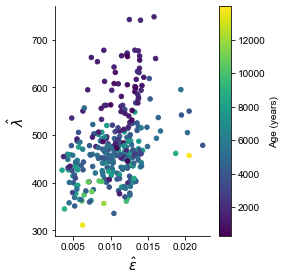

In [12]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
eps_jt = test_df.eps_jt.values
lambda_jt = test_df.scale_marginal.values
age = test_df.AvgDate_calBP.values
im = ax.scatter(eps_jt, lambda_jt, c=age, s=20)
debox(ax);
fig.colorbar(im, label=r'Age (years)');
ax.set_xlabel(r'$\hat{\epsilon}$', fontsize=14)
ax.set_ylabel(r'$\hat{\lambda}$', fontsize=14)

In [13]:
# Reading in the CSV with all of the simulation results
chrX_hapsim_df = pd.read_csv('../../results/hap_copying/simulations/jump_rate_est_sims_ceu_real_chrX.csv')
chrX_hapsim_df.head()

,scenario,Ne,scale_marginal,se_scale_marginal,scale_jt,eps_jt,se_scale_jt,se_eps_jt,n_panel,n_snps,ta,min_maf,seed
0,SerialConstant,10000,809.836054,4.179890,811.423864,0.011611,137.981242,0.000206,49.0,187165.0,10.0,5,42
1,SerialConstant,10000,870.825554,4.403957,871.474276,0.006551,99.463677,0.000124,49.0,187165.0,15.0,5,42
2,SerialConstant,10000,790.228755,4.049053,791.268439,0.008469,123.242022,0.000174,49.0,187165.0,17.0,5,42
3,SerialConstant,10000,839.006868,4.239120,839.933998,0.009002,103.383608,0.000201,49.0,187165.0,19.0,5,42
4,SerialConstant,10000,782.446199,4.070916,783.354878,0.007652,119.227691,0.000201,49.0,187165.0,25.0,5,42


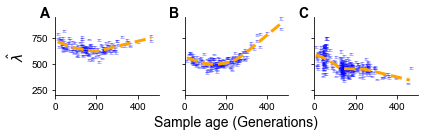

In [29]:
fig, ax = plt.subplots(1,3, figsize=(6,2), sharex=True, sharey=True)

# AXIS 1 : Tennessen et al model
filt_df = chrX_hapsim_df[chrX_hapsim_df.scenario == 'TennessenEuropean']
ax[0].errorbar(rand_jitter(filt_df.ta), filt_df.scale_marginal, 
               yerr=2*filt_df.se_scale_marginal, capsize=2, linestyle='none', color='blue', alpha=0.3)

z = lowess(filt_df.scale_marginal, rand_jitter(filt_df.ta), frac=1/2)
ax[0].plot(z[:,0], z[:,1], color='orange', lw=3, linestyle='--')
# print(z)
debox(ax[0]);


filt_df = chrX_hapsim_df[chrX_hapsim_df.scenario == 'IBDNeUK10K']
ax[1].errorbar(rand_jitter(filt_df.ta), filt_df.scale_marginal,
               yerr=2*filt_df.se_scale_marginal, capsize=2, linestyle='none', color='blue', alpha=0.3)

z = lowess(filt_df.scale_marginal, rand_jitter(filt_df.ta), frac=1/2)
ax[1].plot(z[:,0], z[:,1], color='orange', lw=3, linestyle='--')
debox(ax[1]);

im2 = ax[2].errorbar(rand_jitter(age_gen, scale=1e-3), 
                     marginal_lambda, 
                     yerr=2*marginal_lambda_se,  
                     color='blue', linestyle='none', capsize=2, alpha=0.3)

z = lowess(marginal_lambda, rand_jitter(age_gen), frac=1/2)
ax[2].plot(z[:,0], z[:,1], color='orange', lw=3, linestyle='--', zorder=100)
debox(ax[2]);

# Setting some labeling
ax[0].set_ylim(200,950)
ax[0].set_xlim(0,500)
label_multipanel(ax, ['A','B','C'], fontsize=14, fontweight='bold', va='top', ha='right')
# ax[0].set_title(r'Tennessen et al (2012)', fontsize=12)
# ax[1].set_title(r'IBDNe UK10K (2015)', fontsize=12)
# ax[2].set_title(r'1240K Data', fontsize=12)

ax[0].set_ylabel(r'$\hat{\lambda}$', fontsize=14)
ax[1].set_xlabel('Sample age (Generations)', fontsize=14);
plt.tight_layout()
plt.savefig(supp_figdir + 'copying_rate_demography_chrX_experiment.pdf', dpi=300, bbox_inches='tight')